# # Case: Walmart Recruiting - Store Sales Forecasting.

# # Bibliotecas utilizadas.

In [1]:
# importando todas as bibliotecas necessárias
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import timedelta

from mpl_toolkits import mplot3d


from sklearn.ensemble import RandomForestRegressor
#from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

# # 1. Entendendo o problema de Negócio

O Walmart é uma corporação de varejo que opera como uma rede de supermercados. Neste case o Walmart forneceu dados de 45 lojas onde em cada uma delas há 99 departamentos distribuidas no tempo de 2010-02-05 á 2012-11-1. Nos dados diponibilizados  temos também dados das vendas semanais de cada par loja/departamento.Além disso, o Walmart tem uma politica de remarcação de preços promocionais ao londo do ano, principalmente em datas que precedem feriados importantes.

**Diante disso existe um problema de negócio a ser descoberto:** 

**1.** Qual o o impacto dos feriados nas vendas das lojas? 

**2.** É possível estimar as vendas das lojas por semana em datas futuras de 2012–11–02 a 2013–07-26? Se sim,quais seriam esses valores?

**obs:** Para isso, nos dados disponibilizados estão inclusos quatro semanas dos principais feriados. São eles:

**- Super Bowl:** 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

**- Labor Day:** 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

**- Thanksgiving:** 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

**- Christmas:** 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
 
 

# # 2. Qual modelo de machine learning será utilizado para abordar o problema?


Há pelo menos dois caminhos a serem seguidos neste case: 

**a) Séries Temporais:** Uma vez que as vendas estão dispostas ao longo do tempo e temos que prever para datas futuras um possível modelo seria o clássico ARIMA ou o SARIMA (considera períodos sazonais).

**b) Modelos de regressão:** Uma vez que queremos saber a relção das vendas em relação ao feriado,e prever numericamente valores em datas futuras. 
Como no case há questões como pesos diferentes para feriados na semana, tamanho/tipo da loja e muitas outras variáveis optei por uma modelagem de regressão (Random Forest Regressor)

# # 3 . Métrica utilizada

O Walmart estabeleceu como métrica de demsenpenho o Weighted Mean Absolute Error (WMAE), cuja função matemática é mostrada abaixo.

![](http://latex.codecogs.com/gif.latex?%7BWMAE%7D%20%3D%20%5Cfrac%7B1%7D%7B%5Csum%7Bw_i%7D%7D%20%5Csum_%7Bi%3D1%7D%5En%20w_i%20%7C%20y_i%20-%20%5Chat%7By%7D_i%20%7C)

* n é o número de linhas
* \\( \hat{y}_i \\) é a previsão de vendsas.
* \\( y_i \\) são as vendas atuais.
* \\( w_i \\) São os pesos, onde w = 5 se a semana tiver um feriado, caso contrário será 1.

Nosso objetivo é diminuir essa pontuação o máximo possível, além de prever as vendas semanais. Usaremos essa métrica de desempenho nos modelos de machine leanirng abordados. 

#  # 4. Dados disponibilizados

**Foram disponibilizados 5 arquivos com os seguintes campos:**


**a) features.csv —** Este arquivo contém dados adicionais relacionados à loja, departamento e atividade regional para as datas indicadas. Ele contém os seguintes campos:

**Store —** o número da loja

**Date —** a semana

**Temperature —** temperatura média na região

**Fuel Price —** custo do combustível na região

**MarkDown(1–5) —** dados anônimos relacionados a descontos promocionais que o Walmart está executando. Os dados de redução de preços só estão disponíveis após novembro de 2011 e não estão disponíveis para todas as lojas o tempo todo. Qualquer valor ausente é marcado com um NaN.

**CPI -** o índice de preços ao consumidor

**Unemployment –** a taxa de desemprego

**IsHoliday —** Se o feriado cai durante a semana.

----------------------------------------------------------------------------------------------------------------

**b) train.csv** - (Abrange de 2010–02–05 a 2012-11–01)

**Store —** o número da loja

**Dept —** o número do departamento

**Date —** a semana

**weekly_sales—** vendas para determinado departamento em determinada loja

**IsHoliday —** se a semana é uma semana de feriado especial 

________________________________________________________________________________________________________________

**c) stores.csv —** Este arquivo contém informações anônimas sobre as 45 lojas, indicando o tipo e tamanho da loja.
________________________________________________________________________________________________________________

**d) test.csv —** Este arquivo é idêntico ao train.csv, exceto que retemos as vendas semanais. Você deve prever as vendas para cada trio de loja, departamento e data neste arquivo

_______________________________________________________________________________________________________________
**e) sampleSubmission.csv -** Usado para a submissão deste case no kaggle.

# 4.1 Leitura dos dados

In [2]:
#Leitura dos dados disponibilizados
df_features = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
df_train = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
df_test = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
df_stores = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
df_sample_submission = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

# 4.2 Overview dos dados importados

# a) features.csv

In [3]:
# print das principais informações dos dados e das cinco primeiras linhas.
print(f"Shape of features.csv: {df_features.info()}\n")
df_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
Shape of features.csv: None



,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


**Inferências:**

* Há 12 colunas e 8190 linhas
* A coluna "Date" deveria estar no formato datetime do pandas.
* variáveis categóricas: MarkDown[1 -5], IsHoliday
* De cara já nos deparamos com valores NaN em alguns campos.

In [4]:
# Mostra alguns dados estatístico básicos
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,8190.0,23.000000,12.987966,1.000,12.000000,23.000000,34.000000,45.000000
Temperature,8190.0,59.356198,18.678607,-7.290,45.902500,60.710000,73.880000,101.950000
Fuel_Price,8190.0,3.405992,0.431337,2.472,3.041000,3.513000,3.743000,4.468000
MarkDown1,4032.0,7032.371786,9262.747448,-2781.450,1577.532500,4743.580000,8923.310000,103184.980000
MarkDown2,2921.0,3384.176594,8793.583016,-265.760,68.880000,364.570000,2153.350000,104519.540000
MarkDown3,3613.0,1760.100180,11276.462208,-179.260,6.600000,36.260000,163.150000,149483.310000
MarkDown4,3464.0,3292.935886,6792.329861,0.220,304.687500,1176.425000,3310.007500,67474.850000
MarkDown5,4050.0,4132.216422,13086.690278,-185.170,1440.827500,2727.135000,4832.555000,771448.100000
CPI,7605.0,172.460809,39.738346,126.064,132.364839,182.764003,213.932412,228.976456
Unemployment,7605.0,7.826821,1.877259,3.684,6.634000,7.806000,8.567000,14.313000


**Inferências:**

* Erro: Valores negativos em alguns campos.

# b) train.csv

In [5]:
# print das principais informações dos dados e das cinco primeiras linhas.
print(f"Shape of train.csv: {df_train.info()}\n")
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
Shape of train.csv: None



,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


**Inferências:**

* Há 5 colunas e 421570 linhas.
* A coluna "Date" deveria estar no formato datetime do pandas.
* variáveis categóricas: IsHoliday

In [6]:
# Mostra alguns dados estatístico básicos
df_train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


**Inferências:**

* Erro: Valores negativos nas vendas.

# c) test.csv

In [7]:
# print das principais informações dos dados e das cinco primeiras linhas.
print(f"Shape of test.csv: {df_test.info()}\n")
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB
Shape of test.csv: None



,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


**Inferências:**

* Há 4 colunas e 115064 linhas.
* A coluna "Date" deveria estar no formato datetime do pandas.
* variáveis categóricas: IsHoliday

In [8]:
# Mostra alguns dados estatístico básicos
df_test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


# d) stores.csv

In [9]:
# print das principais informações dos dados e das cinco primeiras linhas.
print(f"Shape of stores.csv: {df_stores.info()}\n")
df_stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
Shape of stores.csv: None



,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


**Inferências:**

* Há 3 colunas e 45 linhas.
* A coluna "Date" deveria estar no formato datetime do pandas.
* variáveis categórica: Type

In [10]:
# Mostra alguns dados estatístico básicos
df_stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


#  # 5. Tratamento e limpeza dos dados 

# 5.1 Elaboração de dois dataframes: um de treino e um de teste

# a) Dados de treino: merge entres os arquivos features.csv, stores.csv e train.csv

In [11]:
# Merge de 3 dataframes para gerar um dataframe final de treino aqui intitulado como"df_train_final"
df_train_final = df_train.merge(df_stores,
                                how='inner', 
                                on='Store')\
                         .merge(df_features, 
                                how='inner', 
                                on=['Store', 'Date', 'IsHoliday'])
                        

In [12]:
# # print das principais informações dos dados e das cinco primeiras linhas.
print(f"Shape of df_train_final.csv: {df_train_final.info()}")
df_train_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
Shape of df_train_final.

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


**Inferências:**

* Há 16 colunas e 421570 linhas.
* A coluna "Date" deveria estar no formato datetime do pandas.
* variáveis categórica: Type, IsHoliday
* Valores com NaN em alguns campos

In [13]:
df_train_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,150681.0,7246.420196,8291.221345,0.270,2240.270000,5347.45000,9210.900000,88646.760000
MarkDown2,111248.0,3334.628621,9475.357325,-265.760,41.600000,192.00000,1926.940000,104519.540000
MarkDown3,137091.0,1439.421384,9623.078290,-29.100,5.080000,24.60000,103.990000,141630.610000
MarkDown4,134967.0,3383.168256,6292.384031,0.220,504.220000,1481.31000,3595.040000,67474.850000


**Observações:**

* Erro: Valores negativos em alguns campos.

# b) Dados de teste: merge entres os arquivos features.csv, stores.csv e test.csv

In [14]:
# Merge de 3 dataframes para gerar um dataframe final de treino aqui intitulado como"df_train_final"
df_test_final = df_test.merge(df_stores,
                              how='inner',
                              on='Store')\
                       .merge(df_features,
                              how='inner',
                              on=['Store', 'Date', 'IsHoliday'])

In [15]:
print(f"Shape of df_test_final.csv: {df_test_final.info()}\n")
df_test_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday     115064 non-null  bool   
 4   Type          115064 non-null  object 
 5   Size          115064 non-null  int64  
 6   Temperature   115064 non-null  float64
 7   Fuel_Price    115064 non-null  float64
 8   MarkDown1     114915 non-null  float64
 9   MarkDown2     86437 non-null   float64
 10  MarkDown3     105235 non-null  float64
 11  MarkDown4     102176 non-null  float64
 12  MarkDown5     115064 non-null  float64
 13  CPI           76902 non-null   float64
 14  Unemployment  76902 non-null   float64
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB
Shape of df_test_final.csv: None



,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
4,1,5,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


**Observações:**

* Há 15 colunas e 115064 linhas.
* A coluna "Date" deveria estar no formato datetime do pandas.
* variáveis categórica: Type, IsHoliday
* Valores com NaN em alguns campos

In [16]:
df_test_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,115064.0,22.238207,12.809930,1.000000,11.000000,22.000000,33.000000,45.000000
Dept,115064.0,44.339524,30.656410,1.000000,18.000000,37.000000,74.000000,99.000000
Size,115064.0,136497.688921,61106.926438,34875.000000,93638.000000,140167.000000,202505.000000,219622.000000
Temperature,115064.0,53.941804,18.724153,-7.290000,39.820000,54.470000,67.350000,101.950000
Fuel_Price,115064.0,3.581546,0.239442,2.872000,3.431000,3.606000,3.766000,4.125000
MarkDown1,114915.0,7689.216439,10698.760716,-2781.450000,1966.460000,4842.290000,9439.140000,103184.980000
MarkDown2,86437.0,3734.051729,8323.495014,-35.740000,180.350000,742.590000,2735.670000,71074.170000
MarkDown3,105235.0,2403.088666,13767.939313,-179.260000,15.100000,78.260000,272.580000,149483.310000
MarkDown4,102176.0,3356.219071,7570.501545,0.220000,155.460000,840.940000,3096.920000,65344.640000
MarkDown5,115064.0,3922.681189,19445.150745,-185.170000,1309.300000,2390.430000,4227.270000,771448.100000


**Observações:**

* Erro: Valores negativos em alguns campos.

# c) Tratar os campos 'Date' e 'Type'

In [17]:
# transformando o tipo do campo 'Date' para datetime
df_train_final.Date = pd.to_datetime(df_train_final.Date)
df_test_final.Date = pd.to_datetime(df_test_final.Date)

Acima foi transformado a variável 'Date' de object para o tipo datetime aceito pela biblioteca pandas.

In [18]:
storetype_values = {'A':3, 'B':2, 'C':1}
df_train_final['Type'] = df_train_final.Type.map(storetype_values)
df_test_final['Type'] = df_test_final.Type.map(storetype_values)

Acima a variável categórica 'Type' foi transformada em variável numérica. Onde,

Type: A, B, C  ----> Type: 3, 2, 1

# d) Elaboração de quatro novas colunas a partir do campo 'Date': Year, Month,Week e Day 

Aqui estamos criando quatro novos campos a partir do campo 'Date' para facilitar as análises e modelagens. Assim temos as seguintes novas colunas:

* Year - respectivo ano de uma data.
* Month - respectivo mês de uma data.
* Day - respectivo dia de uma data.
* Week - valor da semana referente a um ano.

**exemplo:** 

    Date: 2012-10-26
    Year: 2012
    Month: 10
    Day: 26
    Week: 43 (Semana 43 do ano de 2012)
    

In [19]:
# Criação de 4 novos campos: Year, Month,Week e Day 
df_train_final['Year']=df_train_final['Date'].dt.year
df_train_final['Month']=df_train_final['Date'].dt.month
df_train_final['Week']=df_train_final['Date'].dt.week
df_train_final['Day']=df_train_final['Date'].dt.day

df_test_final['Year']=df_test_final['Date'].dt.year
df_test_final['Month']=df_test_final['Date'].dt.month
df_test_final['Week']=df_test_final['Date'].dt.week
df_test_final['Day']=df_test_final['Date'].dt.day


In [20]:
#verificando se a ação acima foi feita de forma correta
df_train_final.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,Day
0,1,1,2010-02-05,24924.50,False,3,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,2,2010-02-05,50605.27,False,3,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
2,1,3,2010-02-05,13740.12,False,3,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
3,1,4,2010-02-05,39954.04,False,3,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
4,1,5,2010-02-05,32229.38,False,3,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5


In [21]:
#verificando se a ação acima foi feita de forma correta
df_test_final.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,Day
0,1,1,2012-11-02,False,3,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,2012,11,44,2
1,1,2,2012-11-02,False,3,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,2012,11,44,2
2,1,3,2012-11-02,False,3,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,2012,11,44,2
3,1,4,2012-11-02,False,3,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,2012,11,44,2
4,1,5,2012-11-02,False,3,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,2012,11,44,2


# e) Verificando os valores ausentes

In [22]:
# para sabar a quantidade de dados totais em cada campo
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  int64         
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

In [23]:
df_train_final.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Year                 0
Month                0
Week                 0
Day                  0
dtype: int64

Consta valores ausentes nos campos 'MarkDown [1-5]'. São valores expressivos em relação a quantidade total de cada um deles. Diante disso, esses valores ausentes serão imputados como 0.

In [24]:
# Trocando os valores ausentes pelo valor numérico 0
df_train_final.loc[df_train_final.MarkDown1.isnull() ,'MarkDown1']= 0
df_train_final.loc[df_train_final.MarkDown2.isnull() ,'MarkDown2']= 0
df_train_final.loc[df_train_final.MarkDown3.isnull() ,'MarkDown3']= 0
df_train_final.loc[df_train_final.MarkDown4.isnull() ,'MarkDown4']= 0
df_train_final.loc[df_train_final.MarkDown5.isnull() ,'MarkDown5']= 0

In [25]:
#checando a quant. de valores ausentes após a mudança
df_train_final.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Year            0
Month           0
Week            0
Day             0
dtype: int64

In [26]:
# checando se existe valores NaN
df_train_final.isnull().values.any()

False

# f) Verificando os valores negativos

In [27]:
# analisando alguns dados estatíticos
df_train_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Type,421570.0,2.410088,0.666337,1.000,2.000000,3.00000,3.000000,3.000000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,421570.0,2590.074819,6052.385934,0.000,0.000000,0.00000,2809.050000,88646.760000
MarkDown2,421570.0,879.974298,5084.538801,-265.760,0.000000,0.00000,2.200000,104519.540000
MarkDown3,421570.0,468.087665,5528.873453,-29.100,0.000000,0.00000,4.540000,141630.610000


Os campos Weekly_Sales,Temperature, MarkDown2, MarkDown3 possuem valores negtivos na coluna 'min'. Desses o único que não faz sentido ter um valor mínimo negativo é o Weekly_Sales, afinal não tem como ter vendas semanais negativas, só positivas ou zeradas.

In [28]:
# checando o numero de valores negativos no campo Weekly_Sales
#Temos 1285 valores negativos nesse campo
df_train_final[df_train_final.Weekly_Sales<0].shape

(1285, 20)

In [29]:
# checando o total de valores no campo Weekly_Sales
# Temos 421570 valores
df_train_final['Weekly_Sales'].shape

(421570,)

A porcentagem de valores negativos é muito pequeno em relação ao todo. Portanto, terá baixo impacto na modelagem a remoção desses valores.

In [30]:
# removendo os valores negativos do campo Weekly_Sales. 
df_train_final = df_train_final[df_train_final.Weekly_Sales >= 0]

In [31]:
# verificando se a ação acima foi feita
df_train_final[df_train_final.Weekly_Sales<0].shape

(0, 20)

Valores negativos do campo Weekly_Sales foram removidos.

# g) Verificando linhas duplicadas.

In [32]:
# Somando todas as linhas duplicadas
df_train_final.duplicated().sum()

0

Não há linhas duplicadas.

#  # 6. Análise exploratória dos dados

# a) Impacto das vendas ao longo dos meses

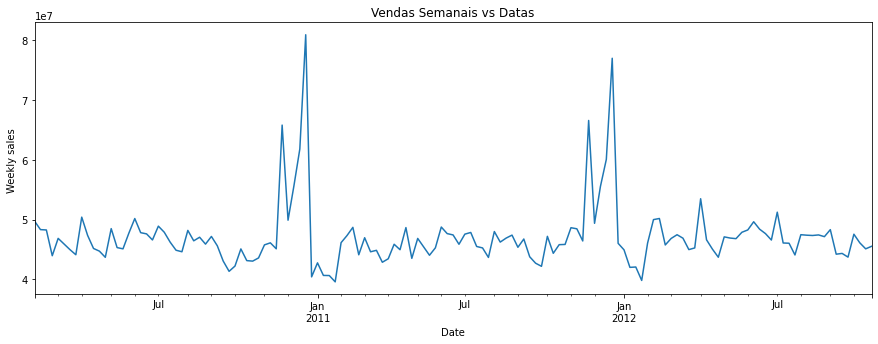

In [33]:
# plotagem da relação das datas com as vendas semanais
plt.figure(figsize=(15,5))
df_train_final.groupby(['Date'])['Weekly_Sales'].sum().plot()
plt.title('Vendas Semanais vs Datas')
plt.ylabel('Weekly sales ');

### Inferências

1. Analisando o gráfico vemos quatro picos, gerando altos impactos nas vendas. Dois deles é no fim de novembro(feriado de ação de graças) e os outros dois é no més de dezembro (natal). Já o feriado do super bowl(fevereiro) e do Labor Day geram um impacto médio no aumento das vendas.

2. Há uma ligeira queda nas vendas em dezembro de 2011 comparado ao mesmo mês em 2012.

3. Há uma sazonalidade no gráfico de vendas semanais ao longo do período de tempo que pode ser facilmente vista pelo gráfico.

4. As vendas semanais médias estão flutuando em torno de 4,8*10^7

# b) Impacto das vendas ao longo das semanas do ano.

<Figure size 720x720 with 0 Axes>

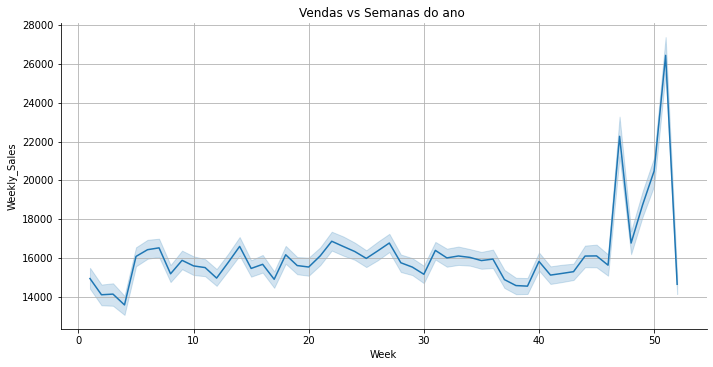

In [34]:
# plotagem da relação das semanas com as vendas
plt.figure(figsize=(10,10)) # dimensao do tamanho da figura
sns.relplot(x = 'Week',y = 'Weekly_Sales',data = df_train_final, kind='line',aspect = 2)
#plotagem
plt.title("Vendas vs Semanas do ano ")
plt.grid()
plt.show();

**Inferência:**

Há flutuações ligeiras das semanas ao longo do ano. Da semana 45 a 50 temos dois picos de vendas devido aos feriados do Natal e de Dia de Ação de Graças que acontecem por essas semanas.

# c) Impacto dos markdowns[1-5] nas vendas semanais

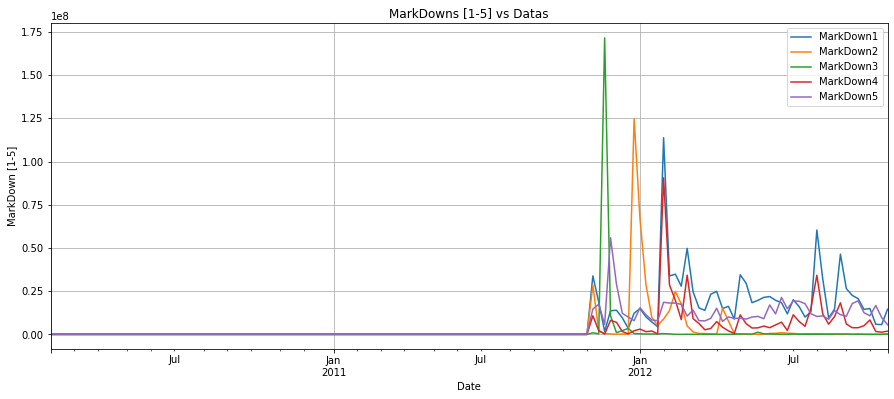

In [35]:
# agrupando cada markdown com o campo date e com isso temos a relação entre os dois.
plt.figure(figsize=(15,6));
df_train_final.groupby(['Date'])['MarkDown1'].sum().plot(label='MarkDown1')
df_train_final.groupby(['Date'])['MarkDown2'].sum().plot(label='MarkDown2')
df_train_final.groupby(['Date'])['MarkDown3'].sum().plot(label='MarkDown3')
df_train_final.groupby(['Date'])['MarkDown4'].sum().plot(label='MarkDown4')
df_train_final.groupby(['Date'])['MarkDown5'].sum().plot(label='MarkDown5')

#legendas e plotagem
plt.grid()
plt.title('MarkDowns [1-5] vs Datas')  
plt.ylabel('MarkDown [1-5]')
plt.legend();

**Inferências:**

1. Não há valores de 'markdowns' disponíveis nas datas anteriores a outubro de 2011.

2. Tivemos picos de 'markdowns' no intervelo de novembro de 2011 a fevereiro de 2012. Intervalo este que é onde ocorrem os seguintes feriados: Natal, Ação de Graças e Super Bowl.
3. Ordem do impacto dos picos citados no item 2:
                                               markdowns3 > markdowns2 > markdowns1 > markdowns4 > markdowns5

# d) Impacto nas vendas com/sem feriados durante a semana

In [36]:
# dimensão do dataframe de treino
df_train_final.shape

(420285, 20)

In [37]:
# print das estatíticas das vendas semanais quando tem feriado durante a semana.
print("Holiday vs Weekly_Sales :\n")


print(df_train_final[df_train_final['IsHoliday']==True]['Weekly_Sales'].describe())


print('\n')

# print das estatíticas das vendas semanais quando não há feriado durante a semana.
print("Non-Holiday vs Weekly_Sales:\n")
print(df_train_final[df_train_final['IsHoliday']==False]['Weekly_Sales'].describe())

Holiday vs Weekly_Sales :

count     29563.000000
mean      17092.566220
std       27249.206776
min           0.000000
25%        2122.830000
50%        7997.860000
75%       21256.915000
max      693099.360000
Name: Weekly_Sales, dtype: float64


Non-Holiday vs Weekly_Sales:

count    390722.000000
mean      15949.958317
std       22347.258698
min           0.000000
25%        2117.300000
50%        7636.080000
75%       20193.912500
max      406988.630000
Name: Weekly_Sales, dtype: float64


**Inferências:**

Médias das vendas quando tem feriado na semana: 17092.566

Médias das vendas quando não tem feriado na semana: 15949.958

Ou seja, os feriados durante a semana geram, em média, mais vendas.
Lembrando que na métrica WMAE o feriado na semana terá peso 5 e,numa situação contrário, terá valor 1.

# e) Média das vendas por lojas

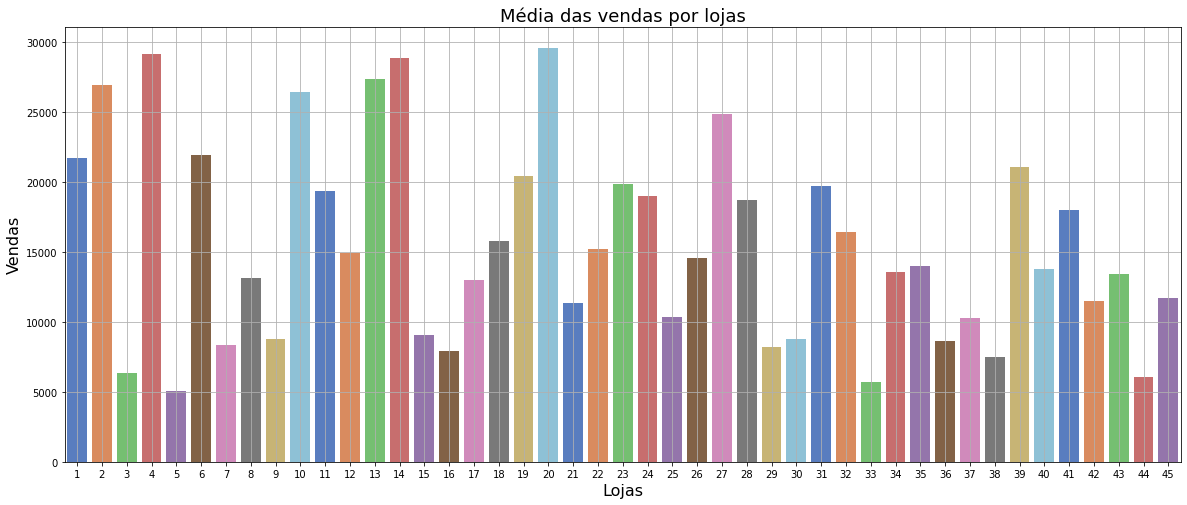

In [38]:
#relacionando a média das vendas semanais e das lojas 
weekly_sales = df_train_final['Weekly_Sales'].groupby(df_train_final['Store']).mean()

plt.figure(figsize=(20,8)) # dimensão da figura
sns.barplot(weekly_sales.index, weekly_sales.values, palette='muted') 

plt.grid()
plt.title('Média das vendas por lojas', fontsize=18)
plt.ylabel('Vendas', fontsize=16)
plt.xlabel('Lojas', fontsize=16)
plt.show()

**Inferências:**

1. N° das lojas que vendem mais: 2,4,6,10,13,14,19,20,27 e 39.
2. Intervalo de vendas das lojas citadas em '1': De 22 a 30 mil vendas


# f) Média das vendas por departamentos

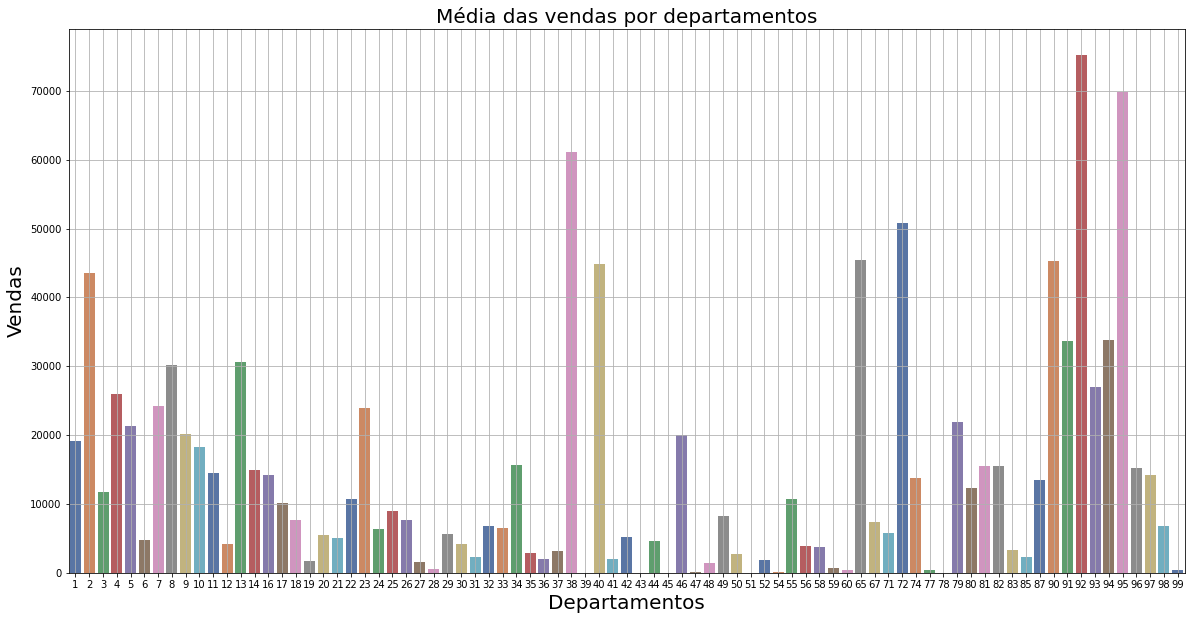

In [39]:
#relacionando a média das vendas semanais e dos departamentos 
weekly_sales = df_train_final['Weekly_Sales'].groupby(df_train_final['Dept']).mean()
plt.figure(figsize=(20,10))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='deep')
#plotagem
plt.grid()
plt.title('Média das vendas por departamentos', fontsize=20)
plt.ylabel('Vendas', fontsize=20)
plt.xlabel('Departamentos', fontsize=20)
plt.show()

**Inferências:**

1. N° dos departamentos que vendem mais: 2,8,13,38,40,65,72,90,91,92,94,95
2. Intervalo de vendas dos departamentos citadas em '1': De 32 a 75 mil vendas
3. Departamentos que não obtiveram vendas segundo os dados disponibilizados: 15,39,43,45,47,51,53,54,57,61,62,63,64,66,68,69,70,73,75,76,78,84,86,88,89,

# g) Média das vendas por tamanho e do tipo da loja

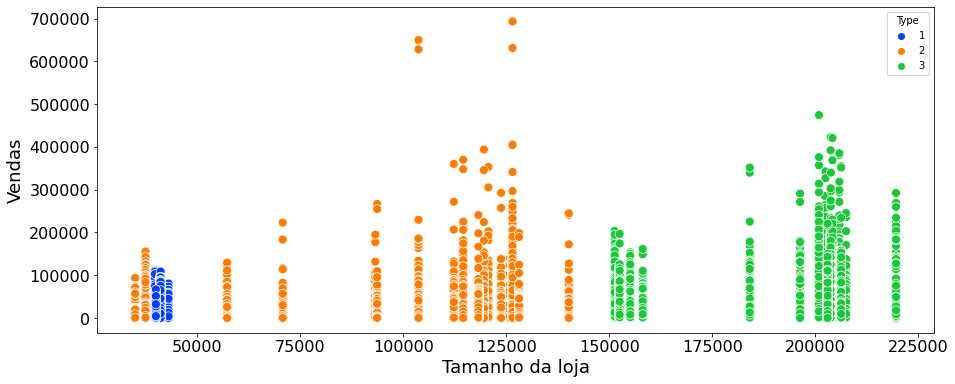

In [40]:
plt.figure(figsize=(15,6))
sns.scatterplot(x=df_train_final.Size, y=df_train_final.Weekly_Sales, hue=df_train_final.Type, s=80, palette='bright');
#plotagem
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Tamanho da loja', fontsize=18)
plt.ylabel('Vendas', fontsize=18);

**Inferências:**

1. Vendas das lojas do tipo '3' > Vendas das lojas do tipo '2' > Vendas das lojas do tipo '1'
2. Lojas menores, até 45 mil [unidade não especificada] , vendem entre 100 a 180 mil [unidade nao especificada]
3. Lojas de tamanho mediano (80 a 44 mil [unidade não especificada]) vendem entre 290 a 430 mil [unidade nao especificada]
4. Lojas maiores(acima de 175 mil [unidade nao especificada])

# h) Matriz de correlação 

In [41]:
#Dython instalado
!pip install dython

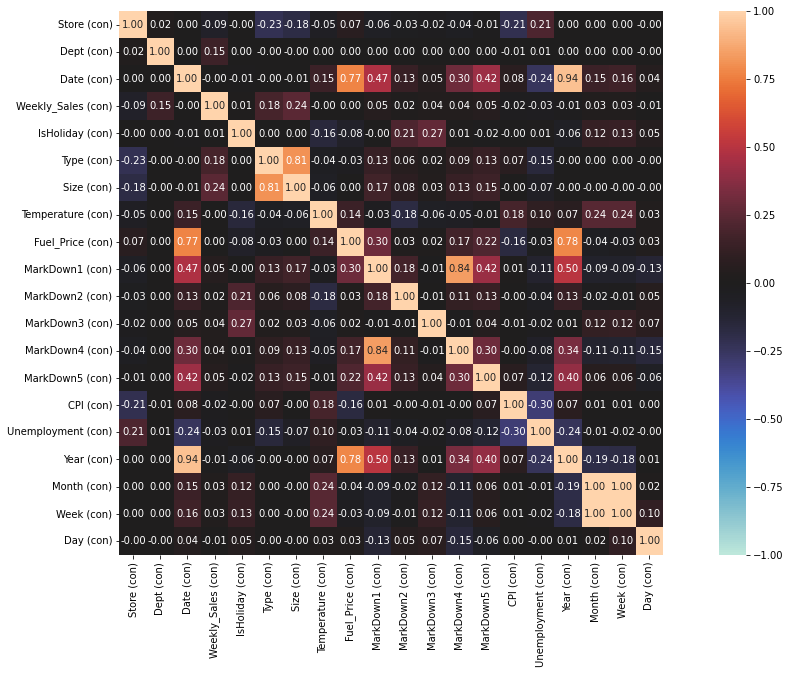

In [42]:
# Dado um conjunto de dados, o dython encontrará automaticamente quais recursos são categóricos e quais são 
#numéricos e calculará uma medida relevante de associação entre cada recurso , plotando tudo como um mapa de 
#calor de fácil leitura. .

#é necessário ser instalado com esse comando: !pip install dython 
from dython import nominal
nominal.associations(df_train_final,figsize=(20,10),mark_columns=True);

**Inferências:**

1. correlação entre [Weekly sales] e [Dept] = 0.15
2. correlação entre [Weekly sales] e [Store] = 0.09
3. correlação entre [Weekly sales] e [Type] = 0.19
4. correlação entre [Weekly sales] e [size] = 0.24
5. correlação entre [Weekly sales] e [Markdown1] = 0.05
6. correlação entre [Weekly sales] e [Markdown2] = 0.02
7. correlação entre [Weekly sales] e [Markdown3] = 0.04
8. correlação entre [Weekly sales] e [Markdown4] = 0.04
9. correlação entre [Weekly sales] e [Markdown5] = 0.05

Todos os demais campos possuem baixa correlação.

# 7. Modelo de Machine Learnig Random Forest Regressor

Função que calcula o WMAE:

In [43]:
# função criada para o calculo da métrica WMAE
# Entradas da função: dataframe, vendas atuais, previsão de vendas
def WMAE(dataset, real, predicted):
  
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1) # Valor do peso. Se w = 5 tem feriado durante a semana e w = 1 caso contrário.
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2) #calculo da formula do WMAE

**O modelo escolhido para este projeto é o Random Forest Regressor. Trata-se de um modelo que possui um método ensemble que garante uma robustez maior e utiliza múltiplas árvores de decisão ('n_estimators' do modelo)  cuja a média das saídas de todas as arvores determinarão o valor final previsto. Dentre os motivos citados no inicio desta análise para a escolha desse modelo há também o fato que terá baixa probabilidade sofrer de overfitting.**

**Obs: a parte ruim do uso deste modelo é seu custo computacional que é alto.**


In [44]:
# função para prever vendas a partir do modelo random forest
def random_forest(n_estimators, max_depth): # Entradas: numero de arvores e a profundidade delas.
    result = [] 
    for estimator in n_estimators:  # O intuito é "testar" numeros de arvores e profundidades diferentes para assim escolher a melhor combinação
        for depth in max_depth:
            wmaes_cv = []       # é aqui onde será quardado o valor de WMAE
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth) # conforme o loop acontece é printado os valores utilizados e encontrados
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3) # dividi-se os dados em dois conjuntos. 70% para treino e 30% para teste.
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)# "Floresta" criada
                RF.fit(x_train, y_train) # "floresta" treinada
                predicted = RF.predict(x_test) # previsão encontradas a paritr dos 30% de dados de teste
                wmaes_cv.append(WMAE(x_test, y_test, predicted)) # add o valor do WMAE a variavel 'wmaes_cv'
            print('WMAE:', np.mean(wmaes_cv)) # print do valor de wmae encontrado
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)}) # cria uma lista com a profundidade e numero de arvores e o valor wmae associado.
    return pd.DataFrame(result) # retorna um novo dataframe com valores comentados na linha anterior

**Abaixo tem a lista dos campos que serão utilizados no modelo e o valor a ser previsto.**

In [45]:
X_train = df_train_final[['Store','Dept','IsHoliday','Size','Week','Type','Year']] # lista de campos do dataframe que serão utilizados
Y_train = df_train_final['Weekly_Sales'] # o valor a ser previsto: Vendas semanais

In [46]:
# conferindo se ação acima foi feita corretamente
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420285 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      420285 non-null  int64
 1   Dept       420285 non-null  int64
 2   IsHoliday  420285 non-null  bool 
 3   Size       420285 non-null  int64
 4   Week       420285 non-null  int64
 5   Type       420285 non-null  int64
 6   Year       420285 non-null  int64
dtypes: bool(1), int64(6)
memory usage: 39.0 MB


In [47]:
n_estimators = [56, 58, 60] # valores para o numero de arvores 
max_depth = [25, 27, 30] # valores para a ser utilizado na profundidade da arvore

random_forest(n_estimators, max_depth) # chamando a função random_forest 

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1531.6450000000002
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1543.9125
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1543.3650000000002
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1566.5175
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1556.4624999999999
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_esti

,Max_Depth,Estimators,WMAE
0,25,56,1531.6450
1,27,56,1543.9125
2,30,56,1543.3650
3,25,58,1566.5175
4,27,58,1556.4625
5,30,58,1533.8500
6,25,60,1552.2500
7,27,60,1557.1050
8,30,60,1553.0150


Pelo gráfico acima o melhor WMAE é 1535.1875

n_estimator: 56

Max_Depth: 25

In [48]:

#treinando o modelo
RF = RandomForestRegressor(n_estimators=56, max_depth=25)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=25, n_estimators=56)

In [49]:
# campos que serão utilizados no modelo
X_test = df_test_final[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test) # previsão dos valores a partir do dataframe de teste

**Submissão dos resultados no Kaggle**

In [50]:
df_sample_submission['Weekly_Sales'] = predict

In [51]:
df_sample_submission

,Id,Weekly_Sales
0,1_1_2012-11-02,32686.824821
1,1_1_2012-11-09,45873.316250
2,1_1_2012-11-16,9334.254260
3,1_1_2012-11-23,36357.108036
4,1_1_2012-11-30,26758.145893
...,...,...
115059,45_98_2013-06-28,3401.825000
115060,45_98_2013-07-05,3903.206071
115061,45_98_2013-07-12,52971.421607
115062,45_98_2013-07-19,6336.969107


In [52]:
df_sample_submission.to_csv('submission.csv', index=False)